# Mod 5 Final Project

Jeremy Owens

Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from HelperFunctions import HelperFunctions as hf

%matplotlib inline
sns.set_style("darkgrid")

## Data Cleaning / EDA

We begin our process by reading in the 2016 School Explorer Dataset and eliminating a variety of columns that are not useful to our analysis

In [43]:
initial_df = pd.read_csv('2016 School Explorer.csv')
schools_df = hf.drop_impractical_columns(initial_df)

In [44]:
schools_df['Student Achievement Rating'] = schools_df['Student Achievement Rating'].apply(lambda x: hf.acheivement_score(x))
schools_df['Student Achievement Rating'].fillna(schools_df['Student Achievement Rating'].median(), inplace=True)

In [45]:
schools_df.dropna(inplace=True)

In [46]:
schools_df = hf.percent_cols_to_float(schools_df)

In [47]:
races_to_drop = ['Percent ELL',
                 'Percent Asian',
                 'Percent Black',
                 'Percent Hispanic',
                 'Percent Black / Hispanic',
                 'Percent White']
race_df = schools_df[['Location Code'] + races_to_drop].set_index('Location Code')
schools_df = schools_df.drop(races_to_drop, axis=1).set_index('Location Code')

In [48]:
schools_df['Grade Low'] = schools_df['Grade Low'].apply(lambda x: hf.make_grades_int(x))
schools_df['Grade High'] = schools_df['Grade High'].apply(lambda x: hf.make_grades_int(x))
schools_df['Grade_range'] = schools_df['Grade High'] - schools_df['Grade Low']
schools_df.drop(['Grade Low', 'Grade High'], axis=1, inplace=True)

### Incorportation of Additional Data

Importing the Pupil to Teacher dataset for joining to main dataset

In [49]:
pupil_teacher_ratio_df = pd.read_csv('2015_-_2016_Final_Class_Size_Report_Pupil-to-Teacher_Ratio__PTR_.csv')
pupil_teacher_ratio_df = pupil_teacher_ratio_df.drop('School Name', axis=1).set_index('DBN')

In [50]:
joined_df = schools_df.join(pupil_teacher_ratio_df)

In [51]:
display(joined_df.info())
display(joined_df.head())
display(race_df.head())

<class 'pandas.core.frame.DataFrame'>
Index: 1217 entries, 01M015 to 84X730
Data columns (total 13 columns):
Economic Need Index                       1217 non-null float64
Student Attendance Rate                   1217 non-null float64
Percent of Students Chronically Absent    1217 non-null float64
Rigorous Instruction %                    1217 non-null float64
Collaborative Teachers %                  1217 non-null float64
Supportive Environment %                  1217 non-null float64
Effective School Leadership %             1217 non-null float64
Strong Family-Community Ties %            1217 non-null float64
Trust %                                   1217 non-null float64
Student Achievement Rating                1217 non-null float64
Average Math Proficiency                  1217 non-null float64
Grade_range                               1217 non-null int64
School Pupil-Teacher Ratio                1083 non-null float64
dtypes: float64(12), int64(1)
memory usage: 173.1+ KB


None

,Economic Need Index,Student Attendance Rate,Percent of Students Chronically Absent,Rigorous Instruction %,Collaborative Teachers %,Supportive Environment %,Effective School Leadership %,Strong Family-Community Ties %,Trust %,Student Achievement Rating,Average Math Proficiency,Grade_range,School Pupil-Teacher Ratio
Location Code,,,,,,,,,,,,,
01M015,0.919,0.94,0.18,0.89,0.94,0.86,0.91,0.85,0.94,2.0,2.17,6,9.2
01M019,0.641,0.92,0.30,0.96,0.96,0.97,0.90,0.86,0.94,4.0,2.98,6,7.0
01M020,0.744,0.94,0.20,0.87,0.77,0.82,0.61,0.80,0.79,2.0,2.54,6,13.3
01M034,0.860,0.92,0.28,0.85,0.78,0.82,0.73,0.89,0.88,4.0,2.47,9,10.9
01M063,0.730,0.93,0.23,0.90,0.88,0.87,0.81,0.89,0.93,3.0,2.54,6,10.6


,Percent ELL,Percent Asian,Percent Black,Percent Hispanic,Percent Black / Hispanic,Percent White
Location Code,,,,,,
01M015,0.09,0.05,0.32,0.60,0.92,0.01
01M019,0.05,0.10,0.20,0.63,0.83,0.06
01M020,0.15,0.35,0.08,0.49,0.57,0.04
01M034,0.07,0.05,0.29,0.63,0.92,0.04
01M063,0.03,0.04,0.20,0.65,0.84,0.10


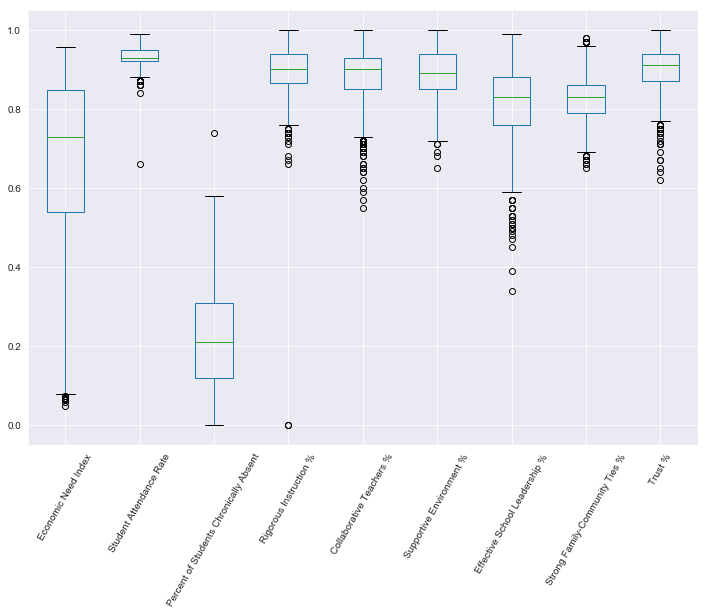

In [52]:
percentage_stats = joined_df.columns[:9]
joined_df.dropna()[percentage_stats].boxplot(figsize=(12,8))
plt.xticks(rotation=60)
plt.show()

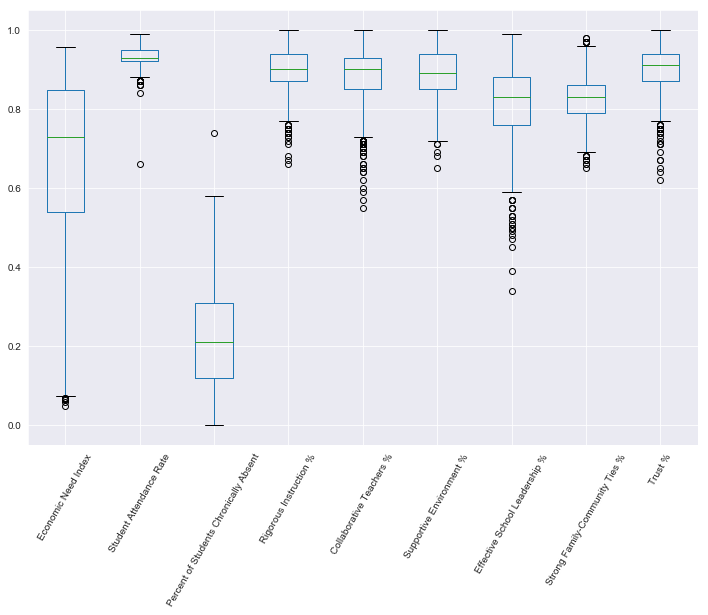

In [53]:
warnings.filterwarnings('ignore')
final_df = joined_df.dropna()
instruction_outliers_indexes = final_df[final_df['Rigorous Instruction %'] == 0].index
final_df.drop(instruction_outliers_indexes, inplace=True)
percentage_stats = final_df.columns[:9]
final_df[percentage_stats].boxplot(figsize=(12,8))
plt.xticks(rotation=60)
plt.show()

No other outliers look especially strange from this box plot, so we then take a glance at the other predictors, make sure nothing else seems out of line.

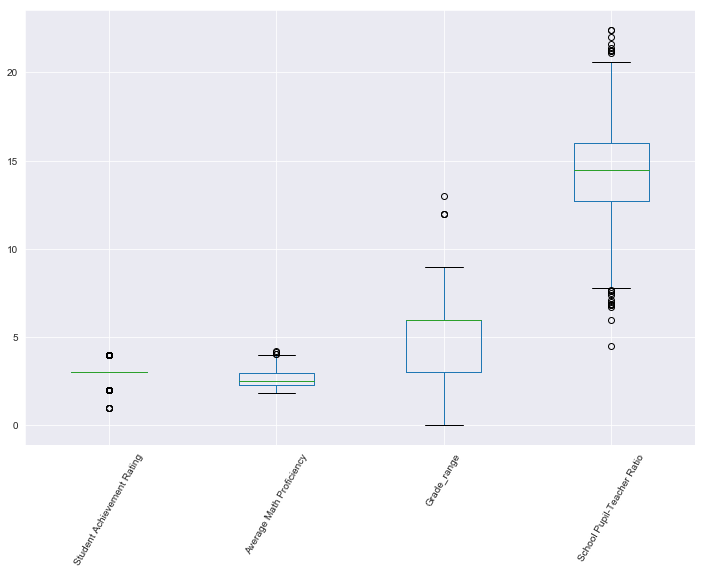

In [54]:
other_stats = final_df.columns[-4:]
final_df[other_stats].boxplot(figsize=(12,8))
plt.xticks(rotation=60)
plt.show()

And all looks good here, so we then move on to the formation of the model.

## Model Formation

In [55]:
upper_quartile = final_df['Average Math Proficiency'].quantile(.75)
y = final_df['Average Math Proficiency'].apply(lambda x: 1 if x >= upper_quartile else 0)
X = final_df.drop('Average Math Proficiency', axis=1)
features = X.columns

In [56]:
X = StandardScaler().fit_transform(X.astype({'Grade_range': 'float64'}))

### PCA Analysis

We first do a PCA analysis to determine, of our predictors, which have the greatest bearing on our classification algorithm.

In [57]:
pca = PCA()
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data=principalComponents)

In [58]:
pca.explained_variance_ratio_

array([0.3974852 , 0.19656456, 0.11404235, 0.06749327, 0.05960156,
       0.04559067, 0.04052775, 0.03527883, 0.02483774, 0.00859648,
       0.0067893 , 0.00319229])

In [59]:
eig_values = pca.explained_variance_
eig_vectors = pca.components_

In [60]:
structure_loading_1 = eig_vectors[0]* np.sqrt(eig_values[0])
str_loading_1 = pd.Series(structure_loading_1, index=features)
str_loading_1.sort_values(ascending=False)

Percent of Students Chronically Absent    0.654653
Economic Need Index                       0.573251
Grade_range                              -0.112935
School Pupil-Teacher Ratio               -0.377194
Student Achievement Rating               -0.449336
Strong Family-Community Ties %           -0.507848
Student Attendance Rate                  -0.644946
Rigorous Instruction %                   -0.733685
Supportive Environment %                 -0.757446
Effective School Leadership %            -0.763228
Trust %                                  -0.784523
Collaborative Teachers %                 -0.822339
dtype: float64

Text(0, 0.5, 'proportion of explained variance')

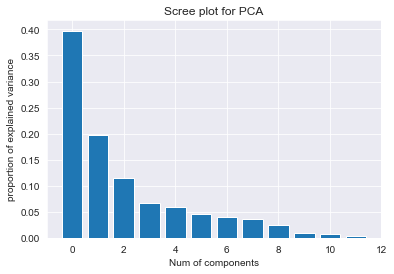

In [61]:
index = np.arange(len(features))
plt.bar(index, pca.explained_variance_ratio_)
plt.title('Scree plot for PCA')
plt.xlabel('Num of components')
plt.ylabel('proportion of explained variance')

Text(0, 0.5, 'explained variance ratio')

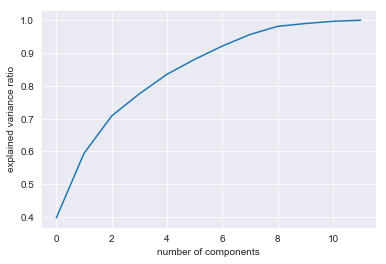

In [62]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('explained variance ratio')

While this was a useful exercise to look at the number of useful factors in this analysis, as we would want to ideally use 8 out of the 12 components to acheive a decent portion of explained variance, we determined it would be beneficial to keep the original 12 predictors in model analysis, and only cull that number should feature importance dictate.

So we next use the recursive feature elimination tool from SKLearn to determine which of our features are superfluous to the model, and would likely introduce too much noise, causing overfit.

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3)

In [64]:
hf.rfe_test(DecisionTreeClassifier(), features, X_train, y_train)

,0,1
0,Economic Need Index,1.00
1,Student Attendance Rate,1.00
5,Supportive Environment %,1.00
9,Student Achievement Rating,1.02
6,Effective School Leadership %,1.10
11,School Pupil-Teacher Ratio,1.14
3,Rigorous Instruction %,1.62
8,Trust %,2.00
7,Strong Family-Community Ties %,2.26
2,Percent of Students Chronically Absent,2.30


In [65]:
hf.rfe_test(RandomForestClassifier(), features, X_train, y_train)

,0,1
0,Economic Need Index,1.00
2,Percent of Students Chronically Absent,1.00
9,Student Achievement Rating,1.00
11,School Pupil-Teacher Ratio,1.00
1,Student Attendance Rate,1.02
5,Supportive Environment %,1.04
6,Effective School Leadership %,1.46
3,Rigorous Instruction %,1.54
7,Strong Family-Community Ties %,1.66
4,Collaborative Teachers %,2.18


In [66]:
hf.rfe_test(XGBClassifier(), features, X_train, y_train)

,0,1
0,Economic Need Index,1.0
2,Percent of Students Chronically Absent,1.0
5,Supportive Environment %,1.0
9,Student Achievement Rating,1.0
11,School Pupil-Teacher Ratio,1.0
1,Student Attendance Rate,2.0
6,Effective School Leadership %,3.0
3,Rigorous Instruction %,4.0
8,Trust %,5.0
7,Strong Family-Community Ties %,6.0


As we can see from the Decision Tree, Random Forest, and XGBoost RFE analysis Grade_range, Trust %, and Collaborative Teachers % consistently are the lowest ranked features for importance, and likely introduce more noise than we need. We therefore will remove them from our dataset.

In [67]:
final_df.drop(['Trust %', 'Grade_range', 'Collaborative Teachers %'], axis=1, inplace=True)
X = final_df.drop('Average Math Proficiency', axis=1)
features = X.columns
final_df.head()

,Economic Need Index,Student Attendance Rate,Percent of Students Chronically Absent,Rigorous Instruction %,Supportive Environment %,Effective School Leadership %,Strong Family-Community Ties %,Student Achievement Rating,Average Math Proficiency,School Pupil-Teacher Ratio
Location Code,,,,,,,,,,
01M015,0.919,0.94,0.18,0.89,0.86,0.91,0.85,2.0,2.17,9.2
01M019,0.641,0.92,0.30,0.96,0.97,0.90,0.86,4.0,2.98,7.0
01M020,0.744,0.94,0.20,0.87,0.82,0.61,0.80,2.0,2.54,13.3
01M034,0.860,0.92,0.28,0.85,0.82,0.73,0.89,4.0,2.47,10.9
01M063,0.730,0.93,0.23,0.90,0.87,0.81,0.89,3.0,2.54,10.6


In [68]:
X = StandardScaler().fit_transform(X)

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3)

### Basic Decision Tree

In [72]:
param_grid = {'max_depth': [3, 5, 10, 15],
              'max_features': [2, 5, 8, 9],
             }

Grid Search found the following optimal parameters: 
max_depth: 5
max_features: 5

[[219  20]
 [ 13  73]]
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       239
           1       0.78      0.85      0.82        86

   micro avg       0.90      0.90      0.90       325
   macro avg       0.86      0.88      0.87       325
weighted avg       0.90      0.90      0.90       325

Accuracy score: 0.9


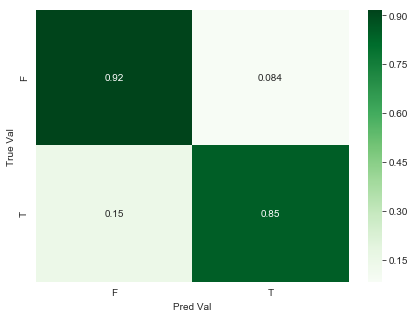

In [73]:
dt_grid_clf = hf.grid_search_classifier(DecisionTreeClassifier(), param_grid, X_train, X_test, y_train, y_test)

AUC: 0.9350004865233044


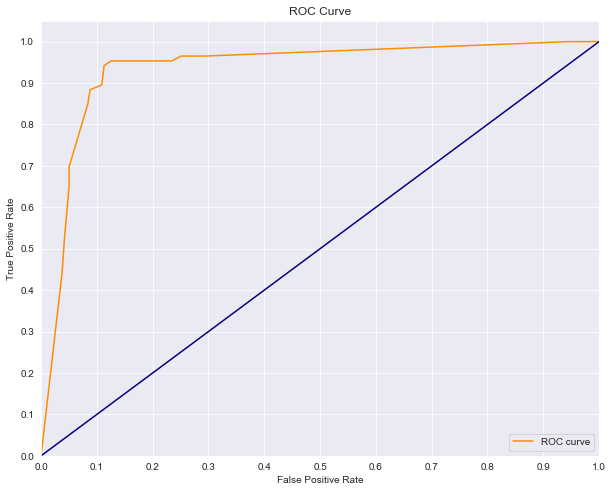

In [74]:
hf.plot_ROC(y_test, X_test, dt_grid_clf)

### KNN

In [75]:
param_grid = {'weights': ['uniform', 'distance'],
              'n_neighbors': [3, 5, 8, 10, 15, 20]
             }

Grid Search found the following optimal parameters: 
n_neighbors: 20
weights: 'distance'

[[231   8]
 [ 17  69]]
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       239
           1       0.90      0.80      0.85        86

   micro avg       0.92      0.92      0.92       325
   macro avg       0.91      0.88      0.90       325
weighted avg       0.92      0.92      0.92       325

Accuracy score: 0.92


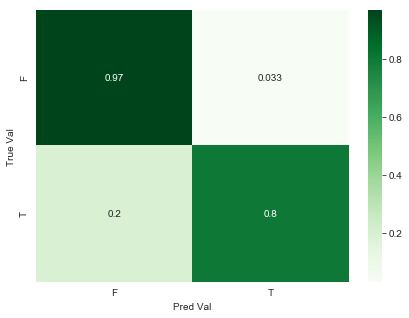

In [76]:
knn_grid_clf = hf.grid_search_classifier(KNeighborsClassifier(), param_grid, X_train, X_test, y_train, y_test)

AUC: 0.969494988809964


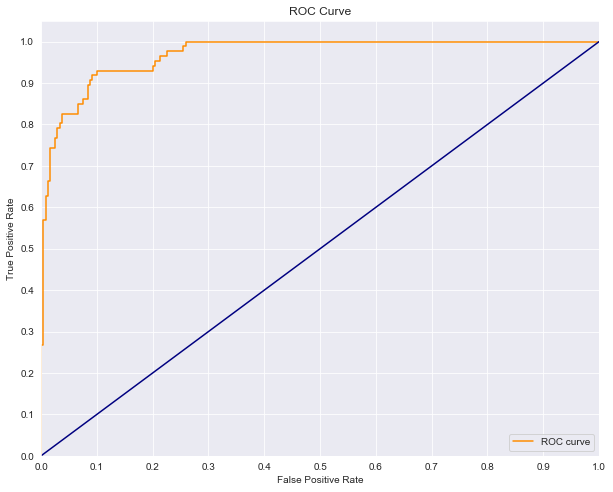

In [77]:
hf.plot_ROC(y_test, X_test, knn_grid_clf)

### Random Forest

In [78]:
param_grid = {'max_depth': [3, 5, 10, 15],
              'max_features': [2, 5, 8, 9],
              'n_estimators': [10, 25, 50, 100, 250, 500]
             }

Grid Search found the following optimal parameters: 
max_depth: 5
max_features: 8
n_estimators: 10

[[226  13]
 [ 14  72]]
              precision    recall  f1-score   support

           0       0.94      0.95      0.94       239
           1       0.85      0.84      0.84        86

   micro avg       0.92      0.92      0.92       325
   macro avg       0.89      0.89      0.89       325
weighted avg       0.92      0.92      0.92       325

Accuracy score: 0.92


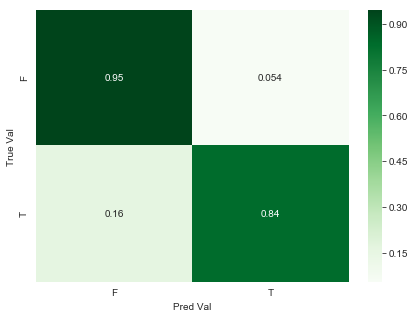

In [79]:
rf_grid_clf = hf.grid_search_classifier(RandomForestClassifier(), param_grid, X_train, X_test, y_train, y_test)

AUC: 0.9650189744088742


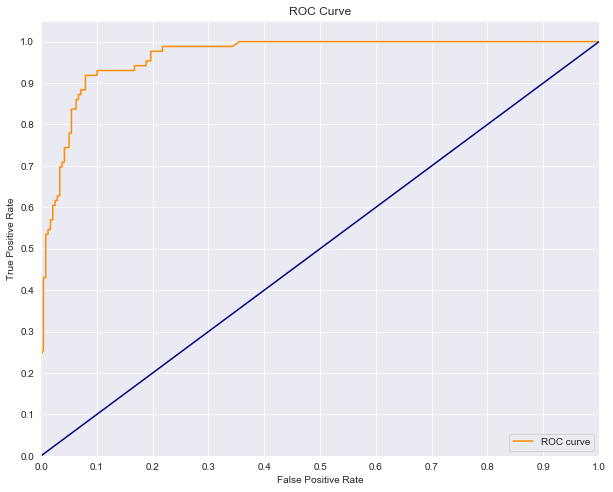

In [80]:
hf.plot_ROC(y_test, X_test, rf_grid_clf)

### SVC

In [57]:
param_grid = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
              'probability': [True],
              'C': [.01, .1, 1, 10, 100],
              'degree': [2, 3, 4],
              'shrinking': [True, False]
             }

Grid Search found the following optimal parameters: 
C: 0.1
degree: 2
kernel: 'linear'
probability: True
shrinking: True

[[236  10]
 [ 14  65]]
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       246
           1       0.87      0.82      0.84        79

   micro avg       0.93      0.93      0.93       325
   macro avg       0.91      0.89      0.90       325
weighted avg       0.93      0.93      0.93       325

Accuracy score: 0.93


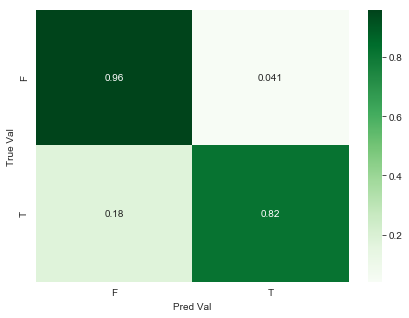

In [58]:
svc_grid_clf = hf.grid_search_classifier(SVC(), param_grid, X_train, X_test, y_train, y_test)

AUC: 0.9718534527117423


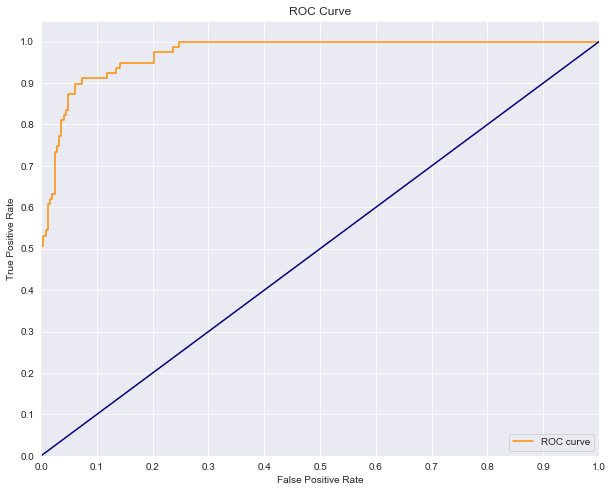

In [59]:
hf.plot_ROC(y_test, X_test, svc_grid_clf)

### XGBoost

In [60]:
param_grid = {'learning_rate': [.01, .1],
              'max_depth': [3, 5, 10, 15],
              'min_child_weight': [2, 5, 10],
              'subsample': [0.7, 0.8],
              'n_estimators': [100, 250, 500, 1000]
             }

Grid Search found the following optimal parameters: 
learning_rate: 0.1
max_depth: 5
min_child_weight: 2
n_estimators: 250
subsample: 0.8

[[229  17]
 [ 14  65]]
              precision    recall  f1-score   support

           0       0.94      0.93      0.94       246
           1       0.79      0.82      0.81        79

   micro avg       0.90      0.90      0.90       325
   macro avg       0.87      0.88      0.87       325
weighted avg       0.91      0.90      0.91       325

Accuracy score: 0.9


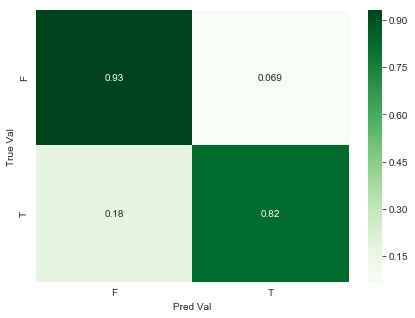

In [61]:
xgb_grid_clf = hf.grid_search_classifier(XGBClassifier(), param_grid, X_train, X_test, y_train, y_test)

AUC: 0.9642379335185758


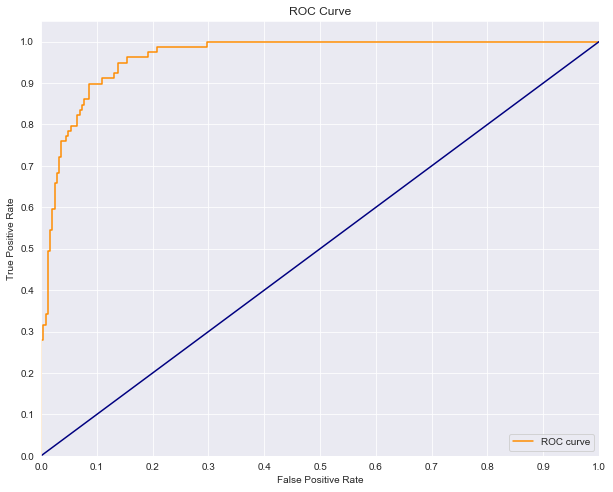

In [62]:
hf.plot_ROC(y_test, X_test, xgb_grid_clf)

## Analysis

In [81]:
upper_quartile = final_df['Average Math Proficiency'].quantile(.75)
final_df['Average Math Proficiency'] = final_df['Average Math Proficiency'].apply(lambda x: 1 if x >= upper_quartile else 0)
X = final_df.drop('Average Math Proficiency', axis=1)

In [82]:
predict_df = pd.DataFrame(rf_grid_clf.predict(StandardScaler().fit_transform(X))).set_index(final_df.index)

In [83]:
final_predict_df = pd.concat([final_df, predict_df], axis=1).rename({0: 'Predicted_class'}, axis=1)
final_predict_df['Match_type'] = final_predict_df['Average Math Proficiency'] - final_predict_df.Predicted_class
final_predict_df.head()

,Economic Need Index,Student Attendance Rate,Percent of Students Chronically Absent,Rigorous Instruction %,Supportive Environment %,Effective School Leadership %,Strong Family-Community Ties %,Student Achievement Rating,Average Math Proficiency,School Pupil-Teacher Ratio,Predicted_class,Match_type
Location Code,,,,,,,,,,,,
01M015,0.919,0.94,0.18,0.89,0.86,0.91,0.85,2.0,0,9.2,0,0
01M019,0.641,0.92,0.30,0.96,0.97,0.90,0.86,4.0,1,7.0,1,0
01M020,0.744,0.94,0.20,0.87,0.82,0.61,0.80,2.0,0,13.3,0,0
01M034,0.860,0.92,0.28,0.85,0.82,0.73,0.89,4.0,0,10.9,0,0
01M063,0.730,0.93,0.23,0.90,0.87,0.81,0.89,3.0,0,10.6,0,0


In [84]:
under_performing_schools = final_predict_df[final_predict_df.Match_type == -1]
len(under_performing_schools)

30

In [85]:
race_under_schools = under_performing_schools.join(race_df['Percent Black / Hispanic'])

In [86]:
schools_to_invest_in = race_under_schools[race_under_schools['Percent Black / Hispanic'] > 0.5][race_under_schools['Economic Need Index'] > 0.5]
schools_to_invest_in

,Economic Need Index,Student Attendance Rate,Percent of Students Chronically Absent,Rigorous Instruction %,Supportive Environment %,Effective School Leadership %,Strong Family-Community Ties %,Student Achievement Rating,Average Math Proficiency,School Pupil-Teacher Ratio,Predicted_class,Match_type,Percent Black / Hispanic
Location Code,,,,,,,,,,,,,
11X180,0.504,0.95,0.13,0.87,0.86,0.90,0.94,3.0,0,16.5,1,-1,0.92
24Q016,0.768,0.96,0.09,0.92,0.94,0.86,0.86,3.0,0,16.0,1,-1,0.91
24Q089,0.708,0.96,0.06,0.84,0.87,0.76,0.79,4.0,0,16.6,1,-1,0.77
27Q282,0.599,0.98,0.01,0.78,0.87,0.66,0.83,3.0,0,18.4,1,-1,0.92
31R065,0.503,0.95,0.12,0.98,0.98,0.90,0.89,3.0,0,14.5,1,-1,0.63


In [87]:
initial_df[['School Name', 'Location Code']].join(schools_to_invest_in[['Economic Need Index', 
                                                                        'Percent Black / Hispanic']], 
                                                  on='Location Code',
                                                  how='right').set_index('Location Code')

,School Name,Economic Need Index,Percent Black / Hispanic
Location Code,,,
11X180,M.S. 180 DR. DANIEL HALE WILLIAMS,0.504,0.92
24Q016,P.S. Q016 THE NANCY DEBENEDITTIS SCHOOL,0.768,0.91
24Q089,P.S. 089 ELMHURST,0.708,0.77
27Q282,KNOWLEDGE AND POWER PREPARATORY ACADEMY VI,0.599,0.92
31R065,P.S. 65 THE ACADEMY OF INNOVATIVE LEARNING,0.503,0.63


t-test economic need for over-performing and under performing schools

logistic regression

baseline model

# Working Zone

In [ ]:
shsat_df = pd.read_csv('D5 SHSAT Registrations and Testers.csv')
print(len(shsat_df))
shsat_df.head()

In [ ]:
shsat_df['Enroll_register'] = round(shsat_df['Number of students who registered for the SHSAT'] / shsat_df['Enrollment on 10/31'], 4)
shsat_df['Enroll_took'] = round(shsat_df['Number of students who took the SHSAT'] / shsat_df['Enrollment on 10/31'], 4)
shsat_df


In [ ]:
new_df = pd.concat([schools_df, pd.get_dummies(schools_df)], axis=1)
new_df.head()

In [ ]:
schools_df['Community School?'] = schools_df['Community School?'].apply(lambda x: 1 if x=='Yes' else 0)

## Model Formation - No Student-Teacher Ratio

In [ ]:
no_ratio_df = final_df.drop('School Pupil-Teacher Ratio', axis=1)

In [ ]:
upper_quartile = no_ratio_df['Average Math Proficiency'].quantile(.75)
y = no_ratio_df['Average Math Proficiency'].apply(lambda x: 1 if x >= upper_quartile else 0)
X = no_ratio_df.drop('Average Math Proficiency', axis=1)
features = X.columns

In [ ]:
X = StandardScaler().fit_transform(X.astype({'Grade_range': 'float64'}))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3)

### KNN

In [ ]:
k_range = range(1, 40)
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    score = f1_score(y_test, y_pred, average='weighted')
    k_scores.append(score)
best_k_score = {'k_score': k_scores.index(max(k_scores))+1, 'f1_score': max(k_scores)}
print(best_k_score)

### CART

In [ ]:
depth_range = range(1,40)
val = []
for depth in depth_range:
    ctree = DecisionTreeClassifier(max_depth = depth)
    depth_score = cross_val_score(ctree, X, y, cv=3)
    val.append(depth_score.mean())
best_dt_score = {'depth_score': val.index(max(val))+1, 'cross_val_score': max(val)}
print(best_dt_score)

### SVC

In [ ]:
svm_types = ['linear', 'poly', 'rbf', 'sigmoid']

In [ ]:
warnings.filterwarnings('ignore')
svm_scores = []
for svm in svm_types:
    svclassifier = SVC(kernel=svm)  
    svclassifier.fit(X_train, y_train) 
    y_pred = svclassifier.predict(X_test)
    svm_scores.append(f1_score(y_test, y_pred, average='weighted'))
best_svm_score = {'svm_type': svm_types[svm_scores.index(max(svm_scores))], 'f1_score': max(svm_scores)}
print(best_svm_score)

### XGBoost

In [ ]:
param_grid = {
    "learning_rate": [.01],
    'max_depth': [5, 10],
    'min_child_weight': [2, 5, 10],
    'subsample': [0.7],
    'n_estimators': [5, 30, 100, 250, 500]
}

In [ ]:
clf = XGBClassifier()
grid_clf = GridSearchCV(clf, param_grid, scoring='f1_weighted', cv=None, n_jobs=1)
grid_clf.fit(X_train, y_train)

best_parameters = grid_clf.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(X_train)
val_preds = grid_clf.predict(X_test)
training_f1_score = f1_score(y_train, training_preds)
val_f1_score = f1_score(y_test, val_preds)

print("")
print("Training f1_score: {:.4}%".format(training_f1_score * 100))
print("Validation f1_score: {:.4}%".format(val_f1_score * 100))

### CART

In [ ]:
depth_range = range(1,40)
val = []
for depth in depth_range:
    ctree = DecisionTreeClassifier(max_depth = depth)
    depth_score = cross_val_score(ctree, X, y, cv=3)
    val.append(depth_score.mean())
best_dt_score = {'depth_score': val.index(max(val))+1, 'cross_val_score': max(val)}
print(best_dt_score)

### KNN

In [ ]:
k_range = range(1, 40)
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    score = f1_score(y_test, y_pred, average='weighted')
    k_scores.append( score)
best_k_score = {'k_score': k_scores.index(max(k_scores))+1, 'f1_score': max(k_scores)}
print(best_k_score)

### SVC

In [ ]:
warnings.filterwarnings('ignore')
svm_scores = []
for svm in svm_types:
    svclassifier = SVC(kernel=svm)  
    svclassifier.fit(X_train, y_train) 
    y_pred = svclassifier.predict(X_test)
    svm_scores.append(f1_score(y_test, y_pred, average='weighted'))
best_svm_score = {'svm_type': svm_types[svm_scores.index(max(svm_scores))], 'f1_score': max(svm_scores)}
print(best_svm_score)

Grid Search found the following optimal parameters: 
max_depth: 10
max_features: 2
n_estimators: 100
[[234  16]
 [ 12  63]]
              precision    recall  f1-score   support

           0       0.95      0.94      0.94       250
           1       0.80      0.84      0.82        75

   micro avg       0.91      0.91      0.91       325
   macro avg       0.87      0.89      0.88       325
weighted avg       0.92      0.91      0.91       325

Accuracy score: 0.91


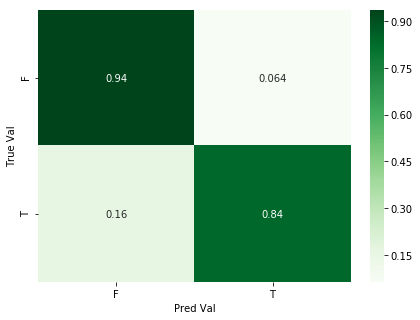

In [35]:
# clf = RandomForestClassifier()
# grid_clf = GridSearchCV(clf, param_grid, scoring='f1_weighted')
# grid_clf.fit(X_train, y_train)

# best_parameters = grid_clf.best_params_

# print("Grid Search found the following optimal parameters: ")
# for param_name in sorted(best_parameters.keys()):
#     print("%s: %r" % (param_name, best_parameters[param_name]))

# y_pred = grid_clf.predict(X_test)

# print(confusion_matrix(y_test, y_pred))
# print(classification_report(y_test, y_pred))
# print('Accuracy score:', round(accuracy_score(y_test, y_pred),2))

# cm = confusion_matrix(y_test, y_pred)
# df_cm = pd.DataFrame(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis],
#                      index =['F','T'], 
#                      columns=['F','T'])
# plt.figure(figsize = (7,5))
# sns.heatmap(df_cm, annot=True, cmap='Greens')
# plt.xlabel('Pred Val')
# plt.ylabel('True Val')
# plt.show()

Grid Search found the following optimal parameters: 
C: 1
degree: 2
kernel: 'linear'
shrinking: True
[[237  13]
 [ 13  62]]
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       250
           1       0.83      0.83      0.83        75

   micro avg       0.92      0.92      0.92       325
   macro avg       0.89      0.89      0.89       325
weighted avg       0.92      0.92      0.92       325

Accuracy score: 0.92


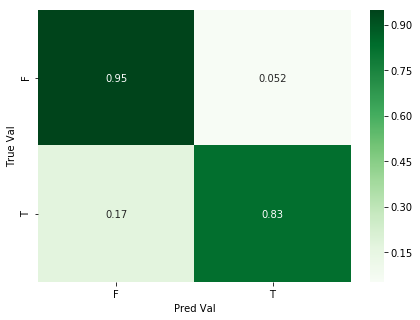

In [37]:
clf = SVC()
grid_clf = GridSearchCV(clf, param_grid, scoring='f1_weighted')
grid_clf.fit(X_train, y_train)

best_parameters = grid_clf.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

y_pred = grid_clf.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print('Accuracy score:', round(accuracy_score(y_test, y_pred),2))

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis],
                     index =['F','T'], 
                     columns=['F','T'])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True, cmap='Greens')
plt.xlabel('Pred Val')
plt.ylabel('True Val')
plt.show()

Grid Search found the following optimal parameters: 
learning_rate: 0.1
max_depth: 3
min_child_weight: 2
n_estimators: 100
subsample: 0.7
[[231  19]
 [ 12  63]]
              precision    recall  f1-score   support

           0       0.95      0.92      0.94       250
           1       0.77      0.84      0.80        75

   micro avg       0.90      0.90      0.90       325
   macro avg       0.86      0.88      0.87       325
weighted avg       0.91      0.90      0.91       325

Accuracy score: 0.9


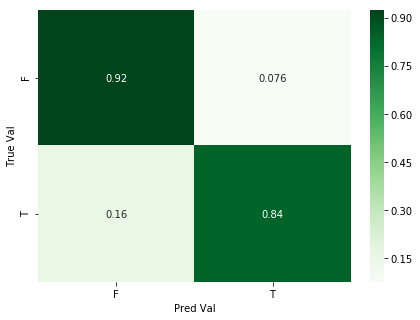

In [39]:
clf = XGBClassifier()
grid_clf = GridSearchCV(clf, param_grid, scoring='f1_weighted', cv=None, n_jobs=1)
grid_clf.fit(X_train, y_train)

best_parameters = grid_clf.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

y_pred = grid_clf.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print('Accuracy score:', round(accuracy_score(y_test, y_pred),2))

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis],
                     index =['F','T'], 
                     columns=['F','T'])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True, cmap='Greens')
plt.xlabel('Pred Val')
plt.ylabel('True Val')
plt.show()

In [26]:
cols_to_drop = ['Supportive Environment %', 
                'Effective School Leadership %', 
                'Trust %', 
                'Collaborative Teachers %']
final_df.drop(cols_to_drop, axis=1, inplace=True)
final_df.head()

,Economic Need Index,Student Attendance Rate,Percent of Students Chronically Absent,Rigorous Instruction %,Strong Family-Community Ties %,Student Achievement Rating,Average Math Proficiency,Grade_range,School Pupil-Teacher Ratio
Location Code,,,,,,,,,
01M015,0.919,0.94,0.18,0.89,0.85,2.0,2.17,6,9.2
01M019,0.641,0.92,0.30,0.96,0.86,4.0,2.98,6,7.0
01M020,0.744,0.94,0.20,0.87,0.80,2.0,2.54,6,13.3
01M034,0.860,0.92,0.28,0.85,0.89,4.0,2.47,9,10.9
01M063,0.730,0.93,0.23,0.90,0.89,3.0,2.54,6,10.6


In [3]:
def acheivement_score(rating):
    '''
    Takes the rating passed to it and returns an integer
    value representing how school meets target goals
    '''
    if rating == 'Exceeding Target':
        return 4
    if rating == 'Meeting Target':
        return 3
    if rating == 'Approaching Target':
        return 2
    if rating == 'Not Meeting Target':
        return 1
    else:
        return None

In [4]:
def percent_cols_to_float(df):
    '''
    For any dataframe passed in, returns a new dataframe where
    values are floats between 0 and 1 representing the respective
    rate or percent in that column
    '''
    for col in df.columns:
        if 'Rate' in col or 'Percent' in col or '%' in col:
            df[col] = df[col].apply(lambda x: float(x.replace('%',''))*.01)
    return df

In [5]:
def make_grades_int(grade):
    '''
    Takes a grade and returns an integer representative of that 
    grade in the school system
    '''
    if grade == 'PK':
        return -1
    elif grade == '0K':
        return 0
    else:
        return int(grade)

In [30]:
def grid_search_classifier(clf, param_grid, scoring):
    grid_clf = GridSearchCV(clf, param_grid, scoring='f1_weighted')
    grid_clf.fit(X_train, y_train)

    best_parameters = grid_clf.best_params_

    print("Grid Search found the following optimal parameters: ")
    for param_name in sorted(best_parameters.keys()):
        print("%s: %r" % (param_name, best_parameters[param_name]))

    y_pred = grid_clf.predict(X_test)

    print()
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print('Accuracy score:', round(accuracy_score(y_test, y_pred),2))

    cm = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis],
                         index =['F','T'], 
                         columns=['F','T'])
    plt.figure(figsize = (7,5))
    sns.heatmap(df_cm, annot=True, cmap='Greens')
    plt.xlabel('Pred Val')
    plt.ylabel('True Val')
    plt.show()
    return grid_clf

In [31]:
def plot_ROC(y_test, X_test, grid_clf):
    fpr, tpr, thresholds = roc_curve(y_test, grid_clf.predict_proba(X_test)[:,1])

    sns.set_style("darkgrid")
    print('AUC: {}'.format(auc(fpr, tpr)))
    plt.figure(figsize=(10,8))
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/10.0 for i in range(11)])
    plt.xticks([i/10.0 for i in range(11)])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

In [22]:
upper_quartile = final_df['Average Math Proficiency'].quantile(.75)
y = final_df['Average Math Proficiency'].apply(lambda x: 1 if x >= upper_quartile else 0)
X = final_df.drop('Average Math Proficiency', axis=1)
features = X.columns

In [23]:
X = StandardScaler().fit_transform(X.astype({'Grade_range': 'float64'}))